In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall

In [4]:
# Load the dataset
url = r"D:\Computer science\Year 3\Project COM3001\injury-pediction-runners-app\Models\day_approach_maskedID_timeseries.csv"
data = pd.read_csv(url)
print(data)

       nr. sessions  total km  km Z3-4  km Z5-T1-T2  km sprinting  \
0               1.0       5.8      0.0          0.6           1.2   
1               0.0       0.0      0.0          0.0           0.0   
2               1.0       0.0      0.0          0.0           0.0   
3               0.0       0.0      0.0          0.0           0.0   
4               1.0       0.0      0.0          0.0           0.0   
...             ...       ...      ...          ...           ...   
42761           1.0      16.0      0.0          0.0           0.0   
42762           0.0       0.0      0.0          0.0           0.0   
42763           1.0      10.0      0.0          0.0           0.0   
42764           1.0      15.1      0.0          0.0           0.0   
42765           1.0      12.2      0.0          0.0           0.0   

       strength training  hours alternative  perceived exertion  \
0                    0.0               0.00                0.11   
1                    0.0             

583
42183


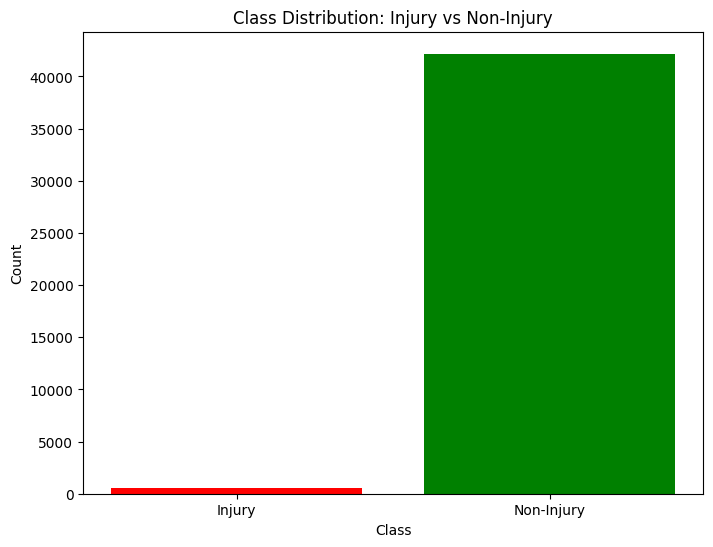

In [6]:
# It counts the first occurance as to the first variable
noninjury, injury = np.bincount(data['injury'])
print(injury)
print(noninjury)

# Labels for the classes
labels = ['Injury', 'Non-Injury']
counts = [injury, noninjury]

# Plotting the bar chart
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.bar(labels, counts, color=['red', 'green'])  # Color for each class
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution: Injury vs Non-Injury')

# Display the plot
plt.show()


In [14]:
# Function to sample a balanced subset
def getBalancedSubset(X_train, samplesPerClass):
    healthySet = pd.DataFrame()
    unhealthySet = pd.DataFrame()

    # Grouping athletes and calculating statistics
    stats = pd.DataFrame(X_train[['Athlete ID', 'injury']].groupby(['Athlete ID', 'injury']).size().reset_index(name='counts'))
    stats = pd.DataFrame(stats[['Athlete ID']].groupby(['Athlete ID']).size().reset_index(name='counts'))
    stats.drop(stats[stats['counts'] < 2].index, inplace=True)
    athleteList = stats['Athlete ID'].unique()

    samplesPerAthlete = int(np.floor(samplesPerClass / len(athleteList)))

    # Sampling for each athlete
    for athlete in athleteList:
        if unhealthySet.empty:
            unhealthySet = X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 0)].sample(samplesPerAthlete, replace=True)
        else:
            unhealthySet = pd.concat([unhealthySet, X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 0)].sample(samplesPerAthlete, replace=True)])

        if healthySet.empty:
            healthySet = X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 1)].sample(samplesPerAthlete, replace=True)
        else:
            healthySet = pd.concat([healthySet, X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 1)].sample(samplesPerAthlete, replace=True)])

    balancedSet = pd.concat([healthySet, unhealthySet])
    return balancedSet

In [ ]:
# Define the features and target
feature_columns = [
    'nr. sessions', 'nr. sessions.1', 'nr. sessions.2', 'nr. sessions.3', 'nr. sessions.4', 'nr. sessions.5', 'nr. sessions.6',
    'total km', 'total km.1', 'total km.2', 'total km.3', 'total km.4', 'total km.5', 'total km.6',
    'km Z3-4', 'km Z3-4.1', 'km Z3-4.2', 'km Z3-4.3', 'km Z3-4.4', 'km Z3-4.5', 'km Z3-4.6',
    'km Z5-T1-T2', 'km Z5-T1-T2.1', 'km Z5-T1-T2.2', 'km Z5-T1-T2.3', 'km Z5-T1-T2.4','km Z5-T1-T2.5', 'km Z5-T1-T2.6',
    'km sprinting', 'km sprinting.1', 'km sprinting.2', 'km sprinting.3', 'km sprinting.4', 'km sprinting.5', 'km sprinting.6', 
    'strength training', 'strength training.1', 'strength training.2', 'strength training.3', 'strength training.4', 'strength training.5', 'strength training.6',
    'hours alternative', 'hours alternative.1', 'hours alternative.2', 'hours alternative.3', 'hours alternative.4', 'hours alternative.5', 'hours alternative.6',
    'perceived exertion', 'perceived exertion.1', 'perceived exertion.2', 'perceived exertion.3', 'perceived exertion.4', 'perceived exertion.5', 'perceived exertion.6',
    'perceived trainingSuccess', 'perceived trainingSuccess.1', 'perceived trainingSuccess.2', 'perceived trainingSuccess.3', 'perceived trainingSuccess.4', 'perceived trainingSuccess.5', 'perceived trainingSuccess.6', 
    'perceived recovery', 'perceived recovery.1', 'perceived recovery.2', 'perceived recovery.3', 'perceived recovery.4', 'perceived recovery.5', 'perceived recovery.6'
]
target_column = 'injury'

# Extract features and target
X = data[feature_columns]
Y = data[target_column]
X_train = data[feature_columns + ['Athlete ID', 'injury']]

# Separate features and target
X_balanced = X_train_balanced[feature_columns]
y_balanced = X_train_balanced['injury']
    
# Split into train and test sets
X_train_BOOST, X_test_BOOST, y_train_BOOST, y_test_BOOST = train_test_split(
X_balanced, 
y_balanced,
test_size=0.2,
random_state=42,
stratify=y_balanced
)

In [ ]:
# Reshape data for LSTM (samples, timesteps, features)
# First, identify the base features (without the time steps)
base_features = list(set([col.split('.')[0] for col in feature_columns])) # splits each day into a set of the features
n_features = len(base_features)  # Should be 10 features
n_timesteps = 7  # 7 days

# Initialize LSTM arrays
X_train_LSTM = np.zeros((len(X_train_BOOST), n_timesteps, n_features))
X_test_LSTM = np.zeros((len(X_test_BOOST), n_timesteps, n_features))

# Map each base feature to its position in the feature array
feature_positions = {feature: idx for idx, feature in enumerate(base_features)}

# Fill LSTM arrays
for base_feature in base_features:
    # Get all columns for this feature
    feature_cols = [col for col in feature_columns if col.startswith(base_feature)]
    
    # Sort them by the time step number
    def get_timestep(col):
        # Split by '.' and get the last part
        parts = col.split('.')
        # If there's no number (original feature), return 0
        if len(parts) == 1:
            return 0
        # Get the last part and convert to int
        try:
            return int(parts[-1])
        except ValueError:
            # If conversion fails, it's the original feature
            return 0
    
    # Sort using the new function
    feature_cols.sort(key=get_timestep)
    
    # Fill the arrays
    feature_idx = feature_positions[base_feature]
    for time_idx, col in enumerate(feature_cols):
        X_train_LSTM[:, time_idx, feature_idx] = X_train_BOOST[col].values
        X_test_LSTM[:, time_idx, feature_idx] = X_test_BOOST[col].values

# Keep the same target variables
y_train_LSTM = y_train_BOOST.values
y_test_LSTM = y_test_BOOST.values

# Verify shapes
print("\nFinal shapes verification:")
print("LSTM shapes:")
print(f"X_train_LSTM: {X_train_LSTM.shape}")  # Should be (n_samples, 7, 10)
print(f"X_test_LSTM: {X_test_LSTM.shape}")    # Should be (n_samples, 7, 10)
print(f"y_train_LSTM: {y_train_LSTM.shape}")  # Should be (n_samples,)
print(f"y_test_LSTM: {y_test_LSTM.shape}")    # Should be (n_samples,)

print("\nXGBoost shapes:")
print(f"X_train_BOOST: {X_train_BOOST.shape}") # Should be (n_samples, 70)
print(f"X_test_BOOST: {X_test_BOOST.shape}")   # Should be (n_samples, 70)
print(f"y_train_BOOST: {y_train_BOOST.shape}") # Should be (n_samples,)
print(f"y_test_BOOST: {y_test_BOOST.shape}")   # Should be (n_samples,)


Final shapes verification:
LSTM shapes:
X_train_LSTM: (3225, 7, 10)
X_test_LSTM: (807, 7, 10)
y_train_LSTM: (3225,)
y_test_LSTM: (807,)

XGBoost shapes:
X_train_BOOST: (3225, 70)
X_test_BOOST: (807, 70)
y_train_BOOST: (3225,)
y_test_BOOST: (807,)


In [49]:
# Get count of each unique Athlete ID
id_counts = X_train_balanced['Athlete ID'].value_counts()

# Display the counts
print("Number of occurrences per Athlete ID:")
print(id_counts)

# Get total number of unique IDs
unique_ids = X_train_balanced['Athlete ID'].nunique()
print(f"\nTotal number of unique athletes: {unique_ids}")


Number of occurrences per Athlete ID:
Athlete ID
0     64
54    64
40    64
41    64
42    64
      ..
32    64
33    64
34    64
35    64
71    64
Name: count, Length: 63, dtype: int64

Total number of unique athletes: 63


In [50]:
# Get counts of injuries/non-injuries per athlete
injury_by_athlete = pd.crosstab(X_train_balanced['Athlete ID'], X_train_balanced['injury'])

# Rename columns for clarity
injury_by_athlete.columns = ['Non-Injury', 'Injury']

print("\nInjury distribution per athlete:")
print(injury_by_athlete)

# Get summary statistics
print("\nSummary of injuries per athlete:")
print(injury_by_athlete.describe())


Injury distribution per athlete:
            Non-Injury  Injury
Athlete ID                    
0                   32      32
1                   32      32
2                   32      32
3                   32      32
4                   32      32
...                ...     ...
67                  32      32
68                  32      32
69                  32      32
70                  32      32
71                  32      32

[63 rows x 2 columns]

Summary of injuries per athlete:
       Non-Injury  Injury
count        63.0    63.0
mean         32.0    32.0
std           0.0     0.0
min          32.0    32.0
25%          32.0    32.0
50%          32.0    32.0
75%          32.0    32.0
max          32.0    32.0


In [51]:
# Define the model
model = Sequential()

model.add(LSTM(50, input_shape=(sequence_length, num_features)))  # Return sequences for stacked LSTM
model.add(Dropout(0.2))  # Increase dropout rate

# Add a Dense output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

# Print the model summary
model.summary()

c:\Users\ench0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,251 (47.86 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=20,  # Number of training iterations
    batch_size=32,  # Number of samples per gradient update
    validation_data=(X_test_LSTM, y_test_LSTM),  # Evaluate on the test set during training
    class_weight = {0:1,1:8} # treats instances of 1 as 8 instances
)


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5007 - loss: 1.7701 - precision: 0.4991 - recall: 0.9857 - val_accuracy: 0.4994 - val_loss: 1.1625 - val_precision: 0.4994 - val_recall: 1.0000
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5116 - loss: 1.5190 - precision: 0.5116 - recall: 1.0000 - val_accuracy: 0.4994 - val_loss: 1.0917 - val_precision: 0.4994 - val_recall: 1.0000
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5011 - loss: 1.5222 - precision: 0.5011 - recall: 1.0000 - val_accuracy: 0.4994 - val_loss: 1.1209 - val_precision: 0.4994 - val_recall: 1.0000
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4940 - loss: 1.5255 - precision: 0.4939 - recall: 1.0000 - val_accuracy: 0.4994 - val_loss: 1.1290 - val_precision: 0.4994 - val_recall: 1.0000
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5147 - loss: 1.4826 - precision: 0.5141 - recall: 1.0000 - val_accuracy: 0.5006 - val_loss: 1.

In [55]:
loss, accuracy = model.evaluate(X_test_LSTM, y_test_LSTM)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5503 - loss: 0.8384 - precision: 0.5246 - recall: 0.9825 


ValueError: too many values to unpack (expected 2)

In [56]:
LSTMpredictions = model.predict(X_test_LSTM)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [57]:
# Train an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
model.fit(X_train_BOOST, y_train_BOOST)

# Make predictions
predictions = model.predict(X_train_BOOST)

# Evaluate the model performance
accuracy = accuracy_score(y_train_BOOST, predictions)
precision = precision_score(y_train_BOOST, predictions)
recall = recall_score(y_train_BOOST, predictions)
f1 = f1_score(y_train_BOOST, predictions)
conf_matrix = confusion_matrix(y_train_BOOST, predictions)

# Print results
print("Predictions:", predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:\n", classification_report(y_train_BOOST, predictions))

Predictions: [0 1 1 ... 0 1 1]
Accuracy: 0.9906976744186047
Precision: 1.0
Recall: 0.981401115933044
F1 Score: 0.990613266583229
Confusion Matrix:
 [[1612    0]
 [  30 1583]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1612
           1       1.00      0.98      0.99      1613

    accuracy                           0.99      3225
   macro avg       0.99      0.99      0.99      3225
weighted avg       0.99      0.99      0.99      3225

